<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import biom
import matplotlib
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

cyto_dir = '../sfari/data/cytokines'

amp_dir = '../sfari/data/sra'

In [2]:
cyto_md = pd.read_excel(f'{cyto_dir}/Raw cytokine data.xlsx', index_col=0, skiprows=1)
cyto_md = cyto_md[['IL-6.1', 'TGFb.1', 'IL-1b.1', 'IL-4.1', 'IFN-γ.1']]

amp_md = pd.read_table(f'{amp_dir}/Zurita2019/sample_metadata.txt', index_col=0)
amp_md['host_subject_id'] = list(map(lambda x: int(x.split('.')[0][1:]), amp_md.index))

def replace_f(x, fill):
    if x == '.':
        return fill
    else:
        return float(x)

cyto_md['IL-6.1'] = cyto_md['IL-6.1'].apply(lambda x: replace_f(x, 10.))
cyto_md['IL-4.1'] = cyto_md['IL-4.1'].apply(lambda x: replace_f(x, 10.))
cyto_md['IFN-γ.1'] = cyto_md['IFN-γ.1'].apply(lambda x: replace_f(x, 4.69))

def _standardize(x):
    x = x.astype(np.float32)
    return (x - x.min()) / (x.max() - x.min())
cyto_md = cyto_md.apply(_standardize)


amp_md = pd.merge(amp_md, cyto_md, left_on='host_subject_id', right_index=True)
amp_md.columns = list((map(lambda x: x.replace('.1', ''), amp_md.columns)))
amp_md.columns = list((map(lambda x: x.replace(u'γ', 'gamma'), amp_md.columns)))
amp_md.columns = list((map(lambda x: x.replace('-', ''), amp_md.columns)))

# separate training labels
def train_f(x):
    if np.random.rand() < 0.9:
        return 'Train'
    else:
        return 'Test'
    
amp_md['Train'] = list(map(train_f, amp_md.index))

amp_md.to_csv(f'{amp_dir}/Zurita2019/cytokine_metadata.txt', sep='\t')

Load biom table and save table

In [3]:
table = biom.load_table(f'{amp_dir}/Kang2017/age_sex_match_week0_ogu.biom')
table.filter(amp_md.index)
table.remove_empty()

from biom.util import biom_open
with biom_open(f'{amp_dir}/Zurita2019/deblur/ogus.biom', 'w') as f:
    table.to_hdf5(f, 'ogus')

Run statistical tests on cytokines

In [4]:
sub_md = amp_md[['Status', 'Match_IDs', 'IL6','TGFb', 'IL1b', 'IL4', 'IFNgamma']]
sub_md = sub_md.groupby('Match_IDs').filter(lambda x: len(x) == 2)
sub_md = sub_md.sort_values(['Match_IDs', 'Status'])

cols = ['Match_IDs', 'IL6','TGFb', 'IL1b', 'IL4', 'IFNgamma']
match_cytos = sub_md[cols].groupby('Match_IDs').diff().dropna()
cyto_df = pd.melt(match_cytos, var_name='cytokine', value_name='standardized conc.')

<AxesSubplot:xlabel='cytokine', ylabel='standardized conc.'>

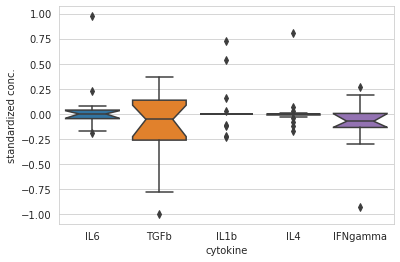

In [5]:
sns.set_style('whitegrid')
sns.boxplot(data=cyto_df, x='cytokine', y='standardized conc.', bootstrap=1000, notch=True)

In [6]:
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon, ttest_rel

asd_md = sub_md.loc[sub_md.Status == 'ASD']
con_md = sub_md.loc[sub_md.Status == 'Control']

cols = [ 'IL6','TGFb', 'IL1b', 'IL4', 'IFNgamma']
for c in cols:
    print(c, ttest_rel(asd_md[c].values, con_md[c].values, alternative='greater'))

IL6 Ttest_relResult(statistic=-0.705296031858368, pvalue=0.755173319057356)
TGFb Ttest_relResult(statistic=1.6432898617050056, pvalue=0.058838012323606886)
IL1b Ttest_relResult(statistic=-0.766474139961866, pvalue=0.7733350439596642)
IL4 Ttest_relResult(statistic=-0.5248488873771839, pvalue=0.6969535623580676)
IFNgamma Ttest_relResult(statistic=1.5307086980563496, pvalue=0.07161339375564173)


In [7]:
wilcoxon(asd_md['IFNgamma'].values, con_md['IFNgamma'].values)

WilcoxonResult(statistic=53.0, pvalue=0.15695518862262656)

In [8]:
ttest_rel(asd_md['IFNgamma'].values, con_md['IFNgamma'].values)

Ttest_relResult(statistic=1.5307086980563496, pvalue=0.14322678751128345)

Look at resulting differentials from songbird

In [9]:
diffs = []
for i in range(1, 13):
    fname = f'{amp_dir}/Zurita2019/cytokine-differentials-{i}/differentials.tsv'
    df = pd.read_table(fname)
    df['sample'] = i
    diffs.append(df)
diffs = pd.concat(diffs)
mean_diff = diffs.groupby('featureid').mean().drop_duplicates()
std_diff = diffs.groupby('featureid').std().drop_duplicates()

In [10]:
from q2_matchmaker._stats import spherical_test

In [11]:
res = []
for col in ['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']:
    D = pd.pivot(diffs[[col, 'sample', 'featureid']], index='sample', columns='featureid', values=col)
    res.append(spherical_test(D.values, center=False))

In [12]:
res

[(False, 3.367184254106944, 40.78279963727703),
 (False, 2.788585425789907, 27.359633888031954),
 (False, 3.5662188835846047, 69.90962162111009),
 (False, 3.5343956429697454, 68.48194860979466),
 (False, 3.9697310911972488, 58.475254372940014)]

Load taxonomy

In [13]:
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
taxa_md = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
# genome
mapping = taxa_md[['genome', 'species']].drop_duplicates().set_index('genome')

Rename feature ids with species names

In [14]:
taxa_names = list(map(lambda x: mapping.loc[str(x)].values[0], mean_diff.index))
mean_diff.index = taxa_names

In [15]:
def filter_f(x):
    bugs = ['Enterococcus', 'Bifidobacterium', 'Akkermansia', 'Lactococcus', 
            'Coprococcus', 'Escherichia', 'Dialister', 'Klebisella', 'Turicibacter', 'Desulfovibrio',
            'Parabacteroides', 'Clostridium',
            'Bacteroides fragilis', #'Alistipes', 
            'Prevotella', 'Ruminococcus']
    for b in bugs:
        if b in x:
            return True
    return False

keep_taxa = list(filter(filter_f, mean_diff.index))
keep_taxa = list(set(keep_taxa))
sub_diffs = mean_diff.loc[keep_taxa, ['IL6','TGFb', 'IL1b', 'IL4', 'IFNgamma']].sort_index()

In [16]:
ast = pd.read_csv('../results/amp-crossectional.csv', index_col=0)

In [17]:
ast = pd.merge(sub_diffs, ast, left_index=True, right_on='species')

In [18]:
sub_diffs.to_csv('../results/supplemental_tables/Table_S5.csv')

In [19]:
ast.to_csv('../results/cytokine_differentials_subset.csv')

In [20]:
ast.sort_values('cluster_name')

,IL6,TGFb,IL1b,IL4,IFNgamma,mean,std,5%,50%,95%,...,cluster_id,cluster_name,GOTU,kingdom,phylum,class,order,family,genus,species
239935,2.594774,-1.363368,-2.483468,-1.547638,6.081401,-0.008351,0.157471,-0.252904,-0.016649,0.239970,...,1,neutral,G000723745,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,Akkermansia muciniphila
420890,-3.852747,-5.545456,7.285565,-5.801750,-0.932195,-0.184159,0.471821,-0.930073,-0.213428,0.615713,...,1,neutral,G000269945,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Lactococcus,Lactococcus garvieae
685038,-0.488934,-0.556733,2.353178,-0.310026,4.941634,0.327995,0.110453,0.134546,0.329746,0.509811,...,1,neutral,G000183345,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli
585057,-0.488934,-0.556733,2.353178,-0.310026,4.941634,0.326262,0.103090,0.164746,0.320822,0.495525,...,1,neutral,G000026345,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli
585056,-0.488934,-0.556733,2.353178,-0.310026,4.941634,0.311221,0.100963,0.138801,0.313703,0.480008,...,1,neutral,G000026325,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411460,1.257573,-0.434837,1.794386,-1.332800,-4.515860,-0.173166,0.062984,-0.278931,-0.172071,-0.076012,...,1,neutral,G000153925,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,[Ruminococcus] torques
53345,-3.451551,3.137496,-1.193662,2.486944,-9.536043,1.133576,0.335144,0.608891,1.115473,1.729427,...,2,num,G001267865,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,Enterococcus durans
1300150,-4.597735,3.288203,-2.608203,4.272079,-12.428702,1.009061,0.289017,0.564970,0.992535,1.524400,...,2,num,G000504125,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,Enterococcus mundtii
333849,-6.000579,3.333895,-5.175545,7.314786,-15.219337,1.069063,0.291274,0.594296,1.066409,1.579169,...,2,num,G000174395,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,Enterococcus faecium


Cross reference cytokines against differentials

In [21]:
from util import extract_differentials, ranking
from plot import (rankplot, networkplot, vectorplot)

kang_directory = '../sfari/data/sra/Kang2017'

# load differentials
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
amp_diffs = extract_differentials(amp_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_percentile=50, log_probs=True)

In [22]:
mean_diff = diffs.groupby('featureid').mean().drop_duplicates()
std_diff = diffs.groupby('featureid').std().drop_duplicates()

In [23]:
diffs

,featureid,Intercept,IL6,TGFb,IL1b,IL4,IFNgamma,sample
0,1028307,0.659410,-1.096983,0.135430,-2.078428,-1.874350,-0.702405,1
1,1033731,0.657308,3.165902,0.344679,0.740479,1.478875,0.907319,1
2,1033732,0.657308,3.165901,0.344679,0.740480,1.478874,0.907318,1
3,1034345,-1.590761,0.698583,-0.567039,0.452593,1.208016,0.672963,1
4,1035839,-0.517847,1.492043,-0.181790,-4.117985,2.101157,-3.974224,1
...,...,...,...,...,...,...,...,...
222,911133,2.250844,2.282850,-4.022636,-2.211308,3.672505,-3.894874,12
223,927665,3.158782,1.852147,-0.708187,-2.722778,1.747433,-1.769739,12
224,937773,-3.478167,0.632956,-1.161649,-0.108969,-1.096755,1.800823,12
225,997894,-2.745479,0.775396,-0.602240,-0.651185,1.938610,1.940201,12


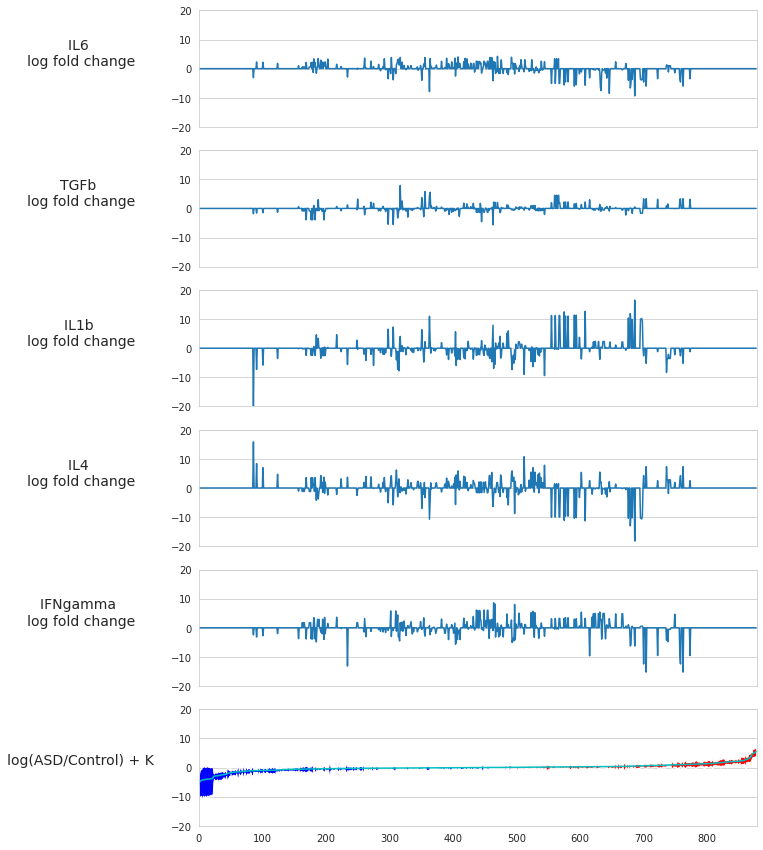

In [24]:
sns.set_style('whitegrid')
cytokine_names = ['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']
fig, ax = plt.subplots(len(cytokine_names) + 1, figsize=(10, 15))
amp_stats = amp_stats.sort_values('mean')
for i, cyto in enumerate(cytokine_names):
    df = diffs[['featureid', cyto, 'sample']].pivot(index='sample', columns='featureid', values=cyto)
    df_stats = ranking(df.T, reference_percentile=50, log_probs=True)
    df_stats.index = list(map(str, df_stats.index))
    df_stats = df_stats.reindex(index=amp_stats.index).fillna(0)
    df_stats['ordering'] = np.arange(len(df_stats))
    ax[i].plot(df_stats['mean'])
    #rankplot(df_stats, ax[i], sort_col='ordering')
    ax[i].set_ylabel(f'{cyto} \nlog fold change', rotation=0, labelpad=90, fontsize=14)
    ax[i].set_xticks([])
    ax[i].set_ylim([-20, 20])
    ax[i].set_xlim([0, len(amp_stats)])
rankplot(amp_stats, ax[-1], sort_col='mean')
ax[-1].set_ylim([-20, 20])
ax[-1].set_xlim([0, len(amp_stats)])
ax[-1].grid(False, axis='x')

In [25]:
bugs = ['Enterococcus', 'Bifidobacterium', 
        'Prevotella', 'Desulfovibrio']


def genus_f(x):
    if x in bugs:
        return x
    else:
        return 'Other'

taxa_md['genera'] = taxa_md['genus'].apply(genus_f)
taxa_md['genome'] = taxa_md['genome'].astype(np.int64)

No handles with labels found to put in legend.


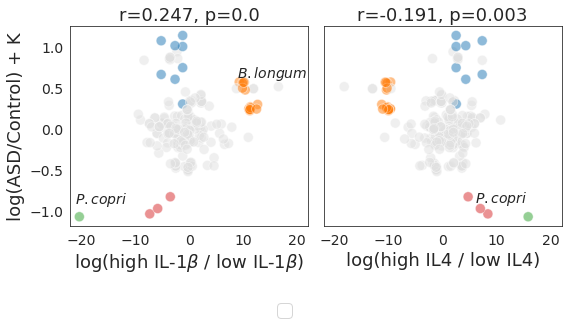

In [104]:
plt.rcParams['text.usetex'] = False
sns.set_style('white')

fs = 18
ls = 14

order = ['Prevotella', 'Enterococcus', 'Bifidobacterium', 
         'Desulfovibrio', 'Other']
palette = dict(zip(bugs, list(sns.color_palette())[:len(bugs)]))
palette['Other'] = '#E0E0E0'
#palette['Other'] = 'w'

# rename for latex
cytokine_k = ['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']
cytokine_v = ['IL6', r'TGF-$\beta$', r'IL-1$\beta$', 'IL4', r'IFN-$\gamma$']
lookup = dict(zip(cytokine_k, cytokine_v))

cytokine_names = cytokine_k

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

def select_f(cyto_name, species_name):    
    if (cyto_name == 'IL4' or cyto_name == 'IL1b') and species_name == 'Prevotella copri':
        return True
    if cyto_name == 'TGFb' and species_name == 'Enterococcus faecalis':
        return True
    if cyto_name == 'IL1b' and species_name == 'Bifidobacterium longum':
        return True
    else:
        return False

species_abv = {'Prevotella copri': '$P. copri$', 
               'Enterococcus faecalis': '$E. faecalis$',
               'Bifidobacterium longum': '$B. longum$'}
all_texts = []
for i, cyto in enumerate(cytokine_names[2:-1]):
    df = diffs[['featureid', cyto, 'sample']].pivot(index='sample', columns='featureid', values=cyto)
    df_stats = ranking(df.T, reference_percentile=50, log_probs=True)
    # realign
    df_stats = pd.merge(df_stats, taxa_md, left_index=True, right_on='genome')
    df_stats['genome'] = df_stats['genome'].astype(np.str)
    df_stats = pd.merge(df_stats, amp_stats, left_on='genome', right_index=True)
    df_stats = df_stats.rename(columns={'mean_x': 'cytokine_mean', 'mean_y': 'amp_mean'})

    df_stats.index = list(map(str, df_stats.index))    
    legend = (i == (len(cytokine_names) - 2))
    sns.scatterplot(data=df_stats, x='cytokine_mean', y='amp_mean', hue='genera', 
                    ax=ax[i], legend=legend, 
                    s=100, hue_order=order, palette=palette, alpha=0.5)
    ax[i].set_xlabel(f'log(high {lookup[cyto]} / low {lookup[cyto]})', fontsize=fs)    
    ax[i].set_xlim([-22, 22])
    r, p = pearsonr(df_stats['cytokine_mean'], df_stats['amp_mean'])
    r, p = np.round(r, 3), np.round(p, 3)
    #print(r, p)
    ax[i].set_title(f'r={r}, p={p}', fontsize=fs)
    ax[i].tick_params(axis='x', labelsize=ls)
    ax[i].tick_params(axis='y', labelsize=ls)
    
    idx = np.array(list(map(lambda x: select_f(cyto, x), df_stats['species'])))
    sub_taxdata = df_stats.loc[idx]
    sub_taxdata = sub_taxdata.drop_duplicates(subset=['species'])
    x = sub_taxdata['cytokine_mean'].values
    y = sub_taxdata['amp_mean'].values
    s = sub_taxdata['species'].values
    dx, dy = 0, 0
    if cyto == 'IL4': 
        dx, dy = 0, 0.1
    if cyto == 'IL1b': 
        dx, dy = -2, 0.1
        
    texts = [ax[i].text(x[j] + dx, y[j] + dy, species_abv[s[j]], fontsize=14,
                        ha='center', va='center') 
             for j in range(len(x))]
    #all_texts += texts
    adjust_text(texts)

ax[0].set_ylabel('log(ASD/Control) + K', fontsize=fs)

h, l = ax[-1].get_legend_handles_labels() # get labels and handles from last figure
#ax[-1].grid(False)
#ax[-1].set_xticks([])
#ax[-1].set_yticks([])
#ax[-1].axis('off')
#ax[-1].legend(h, l, fontsize=14)

fig.legend(h, l, bbox_to_anchor=(0.5, -0.15), loc = 'lower center', ncol=5, fontsize=fs)
plt.subplots_adjust(bottom=0.1, hspace=0.5)

ax[-1].legend().remove()

plt.tight_layout(w_pad=0)

In [27]:
cytokine_names

['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']

In [28]:
cyto = cytokine_names[2]

df = diffs[['featureid', cyto, 'sample']].pivot(index='sample', columns='featureid', values=cyto)
df_stats = ranking(df.T, reference_percentile=50, log_probs=True)

df_stats = pd.merge(df_stats, taxa_md, left_index=True, right_on='genome')
df_stats['genome'] = df_stats['genome'].astype(np.str)
df_stats = pd.merge(df_stats, amp_stats, left_on='genome', right_index=True)
df_stats = df_stats.rename(columns={'mean_x': 'cytokine_mean', 'mean_y': 'amp_mean'})

In [29]:
dfm = df_stats[['genera', 'species', 'cytokine_mean', 'amp_mean']]
dfm = dfm.loc[dfm.genera != 'Other']

In [30]:
dfm.sort_values('cytokine_mean')

,genera,species,cytokine_mean,amp_mean
785,Prevotella,Prevotella copri,-20.305503,-1.078881
10420,Desulfovibrio,Desulfovibrio piger,-7.286196,-1.043930
7142,Desulfovibrio,Desulfovibrio fairfieldensis,-5.817197,-0.978856
782,Enterococcus,Enterococcus casseliflavus,-5.175545,0.657375
953,Enterococcus,Enterococcus faecium,-5.175545,1.069063
2830,Desulfovibrio,Desulfovibrio desulfuricans,-3.484438,-0.835118
3635,Enterococcus,Enterococcus mundtii,-2.608203,1.009061
36,Enterococcus,Enterococcus faecalis,-2.608203,0.598913
2747,Enterococcus,Enterococcus dispar,-1.203127,0.297045
4074,Enterococcus,Enterococcus faecalis,-1.193662,0.740495


In [31]:
cytokine_names

['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']

Look at the differentials to make sure the ordering is correct

In [32]:
counts = table.to_dataframe().T
counts = counts.loc[amp_md.index]
cols = ['IL6', 'TGFb', 'IL1b', 'IL4']
avg_diffs = diffs[['featureid'] + cols + ['sample']].groupby('featureid').mean()
avg_diffs = avg_diffs[cols]
avg_diffs.index = list(map(str, avg_diffs.index))

taxmd = taxa_md.copy()
taxmd['genome'] = taxmd['genome'].astype(np.str)
taxmd = taxmd.set_index('genome').loc[counts.columns]
taxmd = taxmd[~taxmd.index.duplicated(keep='first')]

In [33]:
def top_balance(cts, vec, k):
    svec = vec.sort_values()
    lo = svec.head(k).index
    hi = svec.tail(k).index
    num = np.log(cts.loc[:, hi] + 1).mean(axis=1)
    denom = np.log(cts.loc[:, lo] + 1).mean(axis=1)
    balance = num - denom
    return balance

def microbe_balance(cts, taxa_md):
    """ \log(\frac{Enterococcus + Bifidobacterium}{Prevotella + Desulfovibrio}) """
    ent = np.log(cts.loc[:, taxa_md['genus'] == 'Enterococcus'] + 1).mean(axis=1)
    bif = np.log(cts.loc[:, taxa_md['genus'] == 'Bifidobacterium'] + 1).mean(axis=1)
    prv = np.log(cts.loc[:, taxa_md['genus'] == 'Prevotella'] + 1).mean(axis=1)
    dsv = np.log(cts.loc[:, taxa_md['genus'] == 'Desulfovibrio'] + 1).mean(axis=1)
    num = ent + bif
    denom = prv + dsv
    balance = num - denom
    return balance

In [108]:
plt.rcParams['text.usetex'] = True

k = 30
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i, cyto in enumerate(cols[2:]):
    il = top_balance(counts, avg_diffs[cyto], k)

    ax[i].scatter(amp_md[cyto], il)
    #ax[i].set_xlabel(cyto)
    ax[i].set_ylabel(f'log(high {cyto} / low {cyto})')
ax[0].set_xlabel('IL-1$\beta$')

Text(0.5, 0, 'IL-1$\x08eta$')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x155122a17d30> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'IL-1$\\x08eta$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/dev/shm/.cache-jmorton/matplotlib/tex.cache/24837cb48e0ba3d6025099cb81f09171.
tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 24837cb48e0ba3d6025099cb81f09171.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Keyboard character used is undefined
(inputenc)                in inputencoding `utf8'.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.19 {\sffamily IL-1$^^H
                        eta$}
No pages of output.
Transcript written on 24837cb48e0ba3d6025099cb81f09171.log.




RuntimeError: latex was not able to process the following string:
b'IL-1$\\x08eta$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/dev/shm/.cache-jmorton/matplotlib/tex.cache/24837cb48e0ba3d6025099cb81f09171.
tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 24837cb48e0ba3d6025099cb81f09171.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Keyboard character used is undefined
(inputenc)                in inputencoding `utf8'.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.19 {\sffamily IL-1$^^H
                        eta$}
No pages of output.
Transcript written on 24837cb48e0ba3d6025099cb81f09171.log.




<Figure size 576x216 with 2 Axes>

<AxesSubplot:xlabel='TGFb', ylabel='Density'>

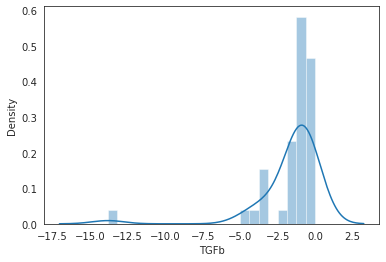

In [35]:
eps = 1e-6
sns.distplot(np.log(amp_md['TGFb'] + eps))

Text(0, 0.5, 'IL-1b')

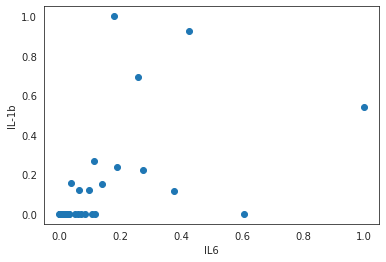

In [36]:
plt.scatter(amp_md['IL6'], amp_md['IL1b'])
plt.xlabel('IL6')
plt.ylabel('IL-1b')

Final figure

IL6 (0.5051464639186183, 0.0007557841899166978)
TGFb (0.452652126524156, 0.002962853520972122)


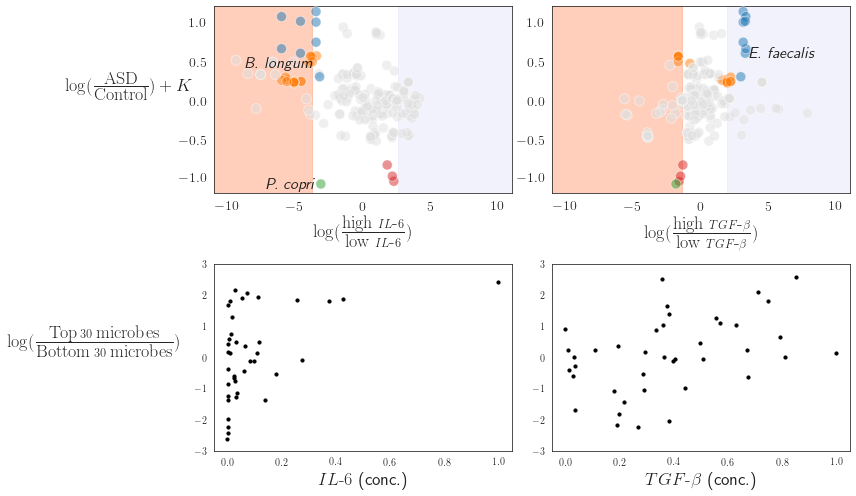

In [112]:
plt.rcParams['text.usetex'] = True
sns.set_style('white')

fs = 18
ls = 14

order = ['Prevotella', 'Enterococcus', 'Bifidobacterium', 
         'Desulfovibrio', 'Other']
palette = dict(zip(bugs, list(sns.color_palette())[:len(bugs)]))
palette['Other'] = '#E0E0E0'
#palette['Other'] = '#808080'
#palette['Other'] = 'w'

# rename for latex
cytokine_k = ['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']
#cytokine_v = ['IL6', r'TGF-$\beta$', r'IL-1$\beta$', 'IL4', r'IFN-$\gamma$']
cytokine_v = [r'IL\textrm{-}6', r'TGF\textrm{-}\beta', r'IL-1$\beta$', 'IL4', r'IFN-$\gamma$']
lookup = dict(zip(cytokine_k, cytokine_v))

cytokine_names = cytokine_k

fig, ax = plt.subplots(2, 2, figsize=(12, 7), sharey=False)

def select_f(cyto_name, species_name):    
    if (cyto_name == 'IL6' or cyto_name == 'IL1b') and species_name == 'Prevotella copri':
        return True
    if cyto_name == 'TGFb' and species_name == 'Enterococcus faecalis':
        return True
    if cyto_name == 'IL6' and species_name == 'Bifidobacterium longum':
        return True
    else:
        return False

species_abv = {'Prevotella copri': 'P. copri', 
               'Enterococcus faecalis': 'E. faecalis',
               'Bifidobacterium longum': 'B. longum'}

## Scatter plots against cytokine concentrations
j = 1
eps = 1e-6
for i, cyto in enumerate(cols[:2]):
    il = top_balance(counts, avg_diffs[cyto], k)
    #il = microbe_balance(counts, taxmd)
    ax[j][i].scatter(amp_md[cyto], il, color='k', s=10)
    print(cyto, pearsonr(amp_md[cyto], il))
    #ax[j][i].set_ylabel(f'log(high {cyto} / low {cyto})')
    ax[j][i].set_ylabel('')
    ax[j][i].set_xlabel('$' + cytokine_v[i] + '$ (conc.)', fontsize=fs)
    ax[j][i].set_ylim([-3, 3])
    ax[j][i].set_xlim([-0.05, 1.05])
    
#ylabel = r'$\log(\frac{Enterococcus + Bifidobacterium}{Prevotella + Desulfovibrio})$'
ylabel = r'$\log(\frac{\textrm{Top} \;' + str(k) + '\; \\textrm{microbes}}{\\textrm{Bottom} \;' + str(k) + '\; \\textrm{microbes}})$'
ax[j][0].set_ylabel(ylabel, fontsize=fs, labelpad=100, rotation=0)
    
all_texts = []
j = 0
for i, cyto in enumerate(cytokine_names[:2]):
    df = diffs[['featureid', cyto, 'sample']].pivot(index='sample', columns='featureid', values=cyto)
    df_stats = ranking(df.T, reference_percentile=50, log_probs=True)
    # realign
    df_stats = pd.merge(df_stats, taxa_md, left_index=True, right_on='genome')
    df_stats['genome'] = df_stats['genome'].astype(np.str)
    df_stats = pd.merge(df_stats, amp_stats, left_on='genome', right_index=True)
    df_stats = df_stats.rename(columns={'mean_x': 'cytokine_mean', 'mean_y': 'amp_mean'})
    
    df_stats.index = list(map(str, df_stats.index))    
    legend = (i == (len(cytokine_names) - 2))
    #ax[j][i].vlines(lo, -1.2, 1.2, 'r', linestyle=':')
    #ax[j][i].vlines(hi, -1.2, 1.2, 'r', linestyle=':')
    lo = df_stats['cytokine_mean'].sort_values().iloc[k]
    hi = df_stats['cytokine_mean'].sort_values().iloc[-k]
    ax[j][i].axvspan(hi, 14, alpha=0.5, color='lavender', zorder=0)
    ax[j][i].axvspan(-14, lo, alpha=0.5, color='lightsalmon', zorder=0)
    
    sns.scatterplot(data=df_stats, x='cytokine_mean', y='amp_mean', hue='genera', 
                    ax=ax[j][i], legend=legend,  zorder=10,
                    s=100, hue_order=order, palette=palette, alpha=0.5)
    xlabel = r'$\log(\frac{\textrm{high }' + lookup[cyto] + '}{ \\textrm{low }' +  lookup[cyto] + '})$'
    
 
    
    ax[j][i].set_xlabel(xlabel, fontsize=fs)
    ax[j][i].set_ylabel("")
    ax[j][i].set_xlim([-11, 11])
    ax[j][i].set_ylim([-1.2, 1.2])
    ax[j][i].tick_params(axis='x', labelsize=ls)
    ax[j][i].tick_params(axis='y', labelsize=ls)
    
    idx = np.array(list(map(lambda x: select_f(cyto, x), df_stats['species'])))
    sub_taxdata = df_stats.loc[idx]
    sub_taxdata = sub_taxdata.drop_duplicates(subset=['species'])
    x = sub_taxdata['cytokine_mean'].values
    y = sub_taxdata['amp_mean'].values
    s = sub_taxdata['species'].values
    dx, dy = 0, 0
    if cyto == 'TGFb': 
        dx, dy = 2.7, 0
    if cyto == 'IL6': 
        dx, dy = -2.2, 0
    
    texts = [ax[j][i].text(x[k] + dx, y[k] + dy, f"\\textit{{{species_abv[s[k]]}}}", fontsize=16,
                        ha='center', va='center', zorder=20) 
             for k in range(len(x))]
    


ax[j][0].set_ylabel(r'$\log(\frac{\textrm{ASD}}{\textrm{Control}}) + K$', 
                    fontsize=fs, rotation=0, labelpad=50)

plt.tight_layout(w_pad=0.5)

Other cytokines

In [115]:
cols[2:]

['IL1b', 'IL4']

IL1b (-0.005059086531958669, 0.9749566572811934)
IL4 (0.256369744373023, 0.1056686648514119)


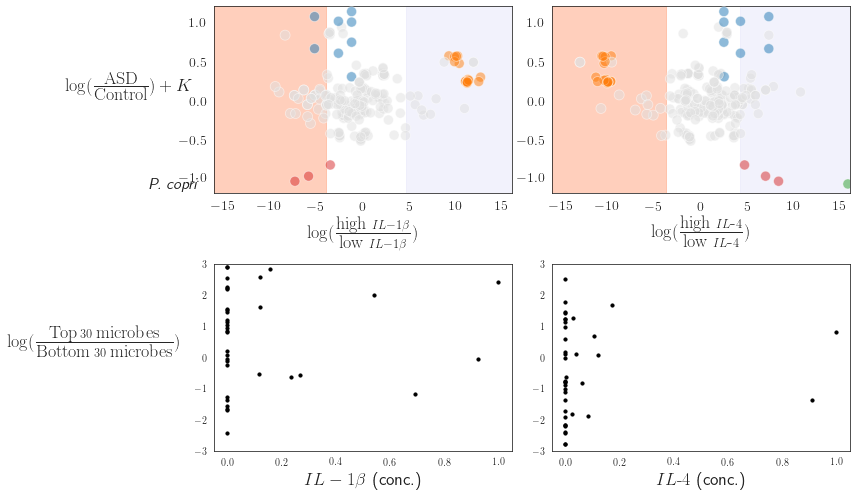

In [124]:
plt.rcParams['text.usetex'] = True
sns.set_style('white')

fs = 18
ls = 14

order = ['Prevotella', 'Enterococcus', 'Bifidobacterium', 
         'Desulfovibrio', 'Other']
palette = dict(zip(bugs, list(sns.color_palette())[:len(bugs)]))
palette['Other'] = '#E0E0E0'
#palette['Other'] = '#808080'
#palette['Other'] = 'w'

# rename for latex
cytokine_k = ['IL1b', 'IL4']
#cytokine_v = ['IL6', r'TGF-$\beta$', r'IL-1$\beta$', 'IL4', r'IFN-$\gamma$']
cytokine_v = [r'IL-1\beta', r'IL\textrm{-}4']
lookup = dict(zip(cytokine_k, cytokine_v))

cytokine_names = cytokine_k

fig, ax = plt.subplots(2, 2, figsize=(12, 7), sharey=False)

def select_f(cyto_name, species_name):    
    if (cyto_name == 'IL6' or cyto_name == 'IL1b') and species_name == 'Prevotella copri':
        return True
    if cyto_name == 'TGFb' and species_name == 'Enterococcus faecalis':
        return True
    if cyto_name == 'IL6' and species_name == 'Bifidobacterium longum':
        return True
    else:
        return False

species_abv = {'Prevotella copri': 'P. copri', 
               'Enterococcus faecalis': 'E. faecalis',
               'Bifidobacterium longum': 'B. longum'}

## Scatter plots against cytokine concentrations
j = 1
eps = 1e-6
for i, cyto in enumerate(cytokine_k):
    il = top_balance(counts, avg_diffs[cyto], k)
    #il = microbe_balance(counts, taxmd)
    ax[j][i].scatter(amp_md[cyto], il, color='k', s=10)
    print(cyto, pearsonr(amp_md[cyto], il))
    #ax[j][i].set_ylabel(f'log(high {cyto} / low {cyto})')
    ax[j][i].set_ylabel('')
    ax[j][i].set_xlabel('$' + cytokine_v[i] + '$ (conc.)', fontsize=fs)
    ax[j][i].set_ylim([-3, 3])
    ax[j][i].set_xlim([-0.05, 1.05])
    
#ylabel = r'$\log(\frac{Enterococcus + Bifidobacterium}{Prevotella + Desulfovibrio})$'
ylabel = r'$\log(\frac{\textrm{Top} \;' + str(k) + '\; \\textrm{microbes}}{\\textrm{Bottom} \;' + str(k) + '\; \\textrm{microbes}})$'
ax[j][0].set_ylabel(ylabel, fontsize=fs, labelpad=100, rotation=0)
    
all_texts = []
j = 0
for i, cyto in enumerate(cytokine_names):
    df = diffs[['featureid', cyto, 'sample']].pivot(index='sample', columns='featureid', values=cyto)
    df_stats = ranking(df.T, reference_percentile=50, log_probs=True)
    # realign
    df_stats = pd.merge(df_stats, taxa_md, left_index=True, right_on='genome')
    df_stats['genome'] = df_stats['genome'].astype(np.str)
    df_stats = pd.merge(df_stats, amp_stats, left_on='genome', right_index=True)
    df_stats = df_stats.rename(columns={'mean_x': 'cytokine_mean', 'mean_y': 'amp_mean'})
    
    df_stats.index = list(map(str, df_stats.index))    
    legend = (i == (len(cytokine_names) - 2))
    #ax[j][i].vlines(lo, -1.2, 1.2, 'r', linestyle=':')
    #ax[j][i].vlines(hi, -1.2, 1.2, 'r', linestyle=':')
    lo = df_stats['cytokine_mean'].sort_values().iloc[k]
    hi = df_stats['cytokine_mean'].sort_values().iloc[-k]
    ax[j][i].axvspan(hi, 16, alpha=0.5, color='lavender', zorder=0)
    ax[j][i].axvspan(-16, lo, alpha=0.5, color='lightsalmon', zorder=0)
    sns.scatterplot(data=df_stats, x='cytokine_mean', y='amp_mean', hue='genera', 
                    ax=ax[j][i], legend=False,  zorder=10,
                    s=100, hue_order=order, palette=palette, alpha=0.5)
    xlabel = r'$\log(\frac{\textrm{high }' + lookup[cyto] + '}{ \\textrm{low }' +  lookup[cyto] + '})$'
    
    ax[j][i].set_xlabel(xlabel, fontsize=fs)
    ax[j][i].set_ylabel("")
    ax[j][i].set_xlim([-16, 16])
    ax[j][i].set_ylim([-1.2, 1.2])
    ax[j][i].tick_params(axis='x', labelsize=ls)
    ax[j][i].tick_params(axis='y', labelsize=ls)
    
    idx = np.array(list(map(lambda x: select_f(cyto, x), df_stats['species'])))
    sub_taxdata = df_stats.loc[idx]
    sub_taxdata = sub_taxdata.drop_duplicates(subset=['species'])
    x = sub_taxdata['cytokine_mean'].values
    y = sub_taxdata['amp_mean'].values
    s = sub_taxdata['species'].values
    dx, dy = 0, 0
    if cyto == 'TGFb': 
        dx, dy = 2.7, 0
    if cyto == 'IL6': 
        dx, dy = -2.2, 0
    
    texts = [ax[j][i].text(x[k] + dx, y[k] + dy, f"\\textit{{{species_abv[s[k]]}}}", fontsize=16,
                        ha='center', va='center', zorder=20) 
             for k in range(len(x))]
    
ax[j][0].set_ylabel(r'$\log(\frac{\textrm{ASD}}{\textrm{Control}}) + K$', 
                    fontsize=fs, rotation=0, labelpad=50)

plt.tight_layout(w_pad=0.5)

In [ ]:
break

In [ ]:
cyto_means = diffs.groupby('featureid').mean()
cyto_means.index = list(map(str, cyto_means.index))
all_stats = pd.merge(amp_stats, cyto_means, left_index=True, right_index=True)
il6 = all_stats['IL6']
tgfb = all_stats['TGFb']
mdiffs = all_stats['mean']

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#ax[0].scatter(il6, mdiffs)
#ax[1].scatter(tgfb, mdiffs)

def default_differential_scatterplot(ax, dat, x, y, cyto):
    ax.set_xlim([-11, 11])
    ax.set_ylabel('log(ASD/Control) + K')
    ax.set_xlabel(f'log(high {cyto}/low {cyto}) + K')
    ax.scatter(x, y)
    sns.scatterplot(data=df_stats, x='cytokine_mean', y='amp_mean', hue='genera', 
                    ax=ax[i], legend=legend, 
                    s=100, hue_order=order, palette=palette, alpha=0.5)

In [ ]:
amp_stats.index

We will list the following microbes

Enterococcus faecalis, TGFb hinted in https://pubmed.ncbi.nlm.nih.gov/18286689/

Prevotella copri, hinted in
- https://pubmed.ncbi.nlm.nih.gov/31607556/
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6854460/
- https://www.nature.com/articles/mi2013116.pdf
- https://elifesciences.org/articles/01202
- https://www.cell.com/cell/fulltext/S0092-8674(16)30659-6

Bifidobacterium longum, IL-1b hinted in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5142200/

